In [93]:
"""Missing."""

'Missing.'

# Пропущенные значения

In [ ]:
import io
import os

import matplotlib.pyplot as plt

# импортируем библиотеку missingno с псевдонимом msno
import missingno as msno
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from numpy.typing import ArrayLike

# в цикле пройдемся по датасетам с заполненными пропусками
# и списком названий соответствующих методов
from sklearn.base import accuracy_score

# создадим объект класса StandardScaler
# сделаем копию датасета
from sklearn.discriminant_analysis import StandardScaler

# создадим объект этого класса с параметрами:
# пять соседей и однаковым весом каждого из них
# fmt: off
# создадим объект класса SimpleImputer с параметром strategy = 'median'
# (для заполнения средним арифметическим используйте strategy = 'mean')
# сделаем копию датасета
# затем импортировать его
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

# теперь импортируем классы моделей, которые мы можем использовать в MICE
from sklearn.linear_model import LinearRegression, LogisticRegression

# from sklearn.ensemble import RandomForestRegressor

# предварительно нам нужно "включить" класс IterativeImputer,
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.linear_model import BayesianRidge

In [ ]:
train_csv_url = os.environ.get("TRAIN_CSV_URL", "")
response = requests.get(train_csv_url)

# импортируем датасет Титаник
titanic = pd.read_csv(io.BytesIO(response.content))

## Выявление пропусков

### Базовые методы

#### Метод `.info()`

In [96]:
# метод .info() соотносит максимальное количество записей
# с количеством записей в каждом столбце
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [97]:
# попробуем преобразовать Age в int
# titanic.Age.astype('int')

#### Методы `.isna()` и `.sum()`

In [98]:
# .isna() выдает True или 1, если есть пропуск,
# .sum() суммирует единицы по столбцам
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [99]:
# пропущенные значения в процентах
print((titanic.isna().sum() / len(titanic)).round(4) * 100)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64


### Библиотека missingno

In [102]:
# сделаем стиль графиков seaborn основным
sns.set()

#### Столбчатая диаграмма пропусков

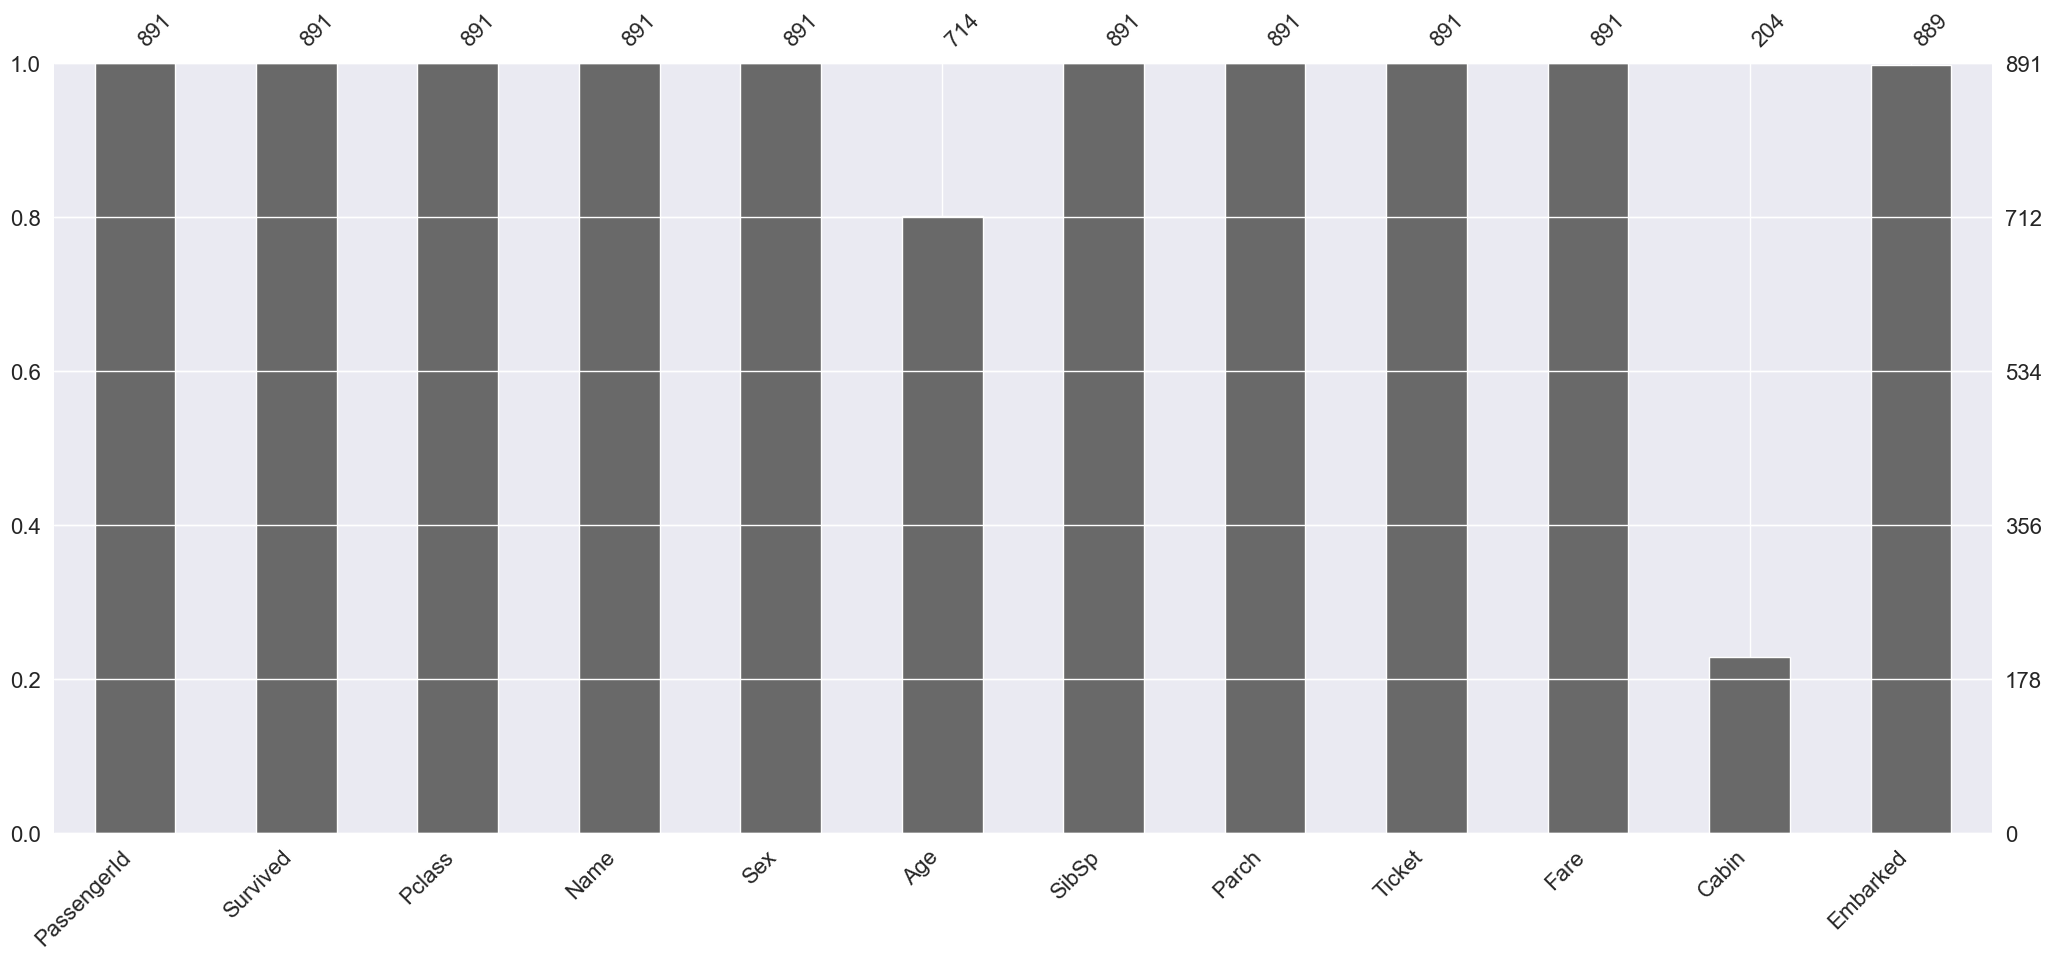

In [103]:
msno.bar(titanic);

#### Матрица пропущенных значений

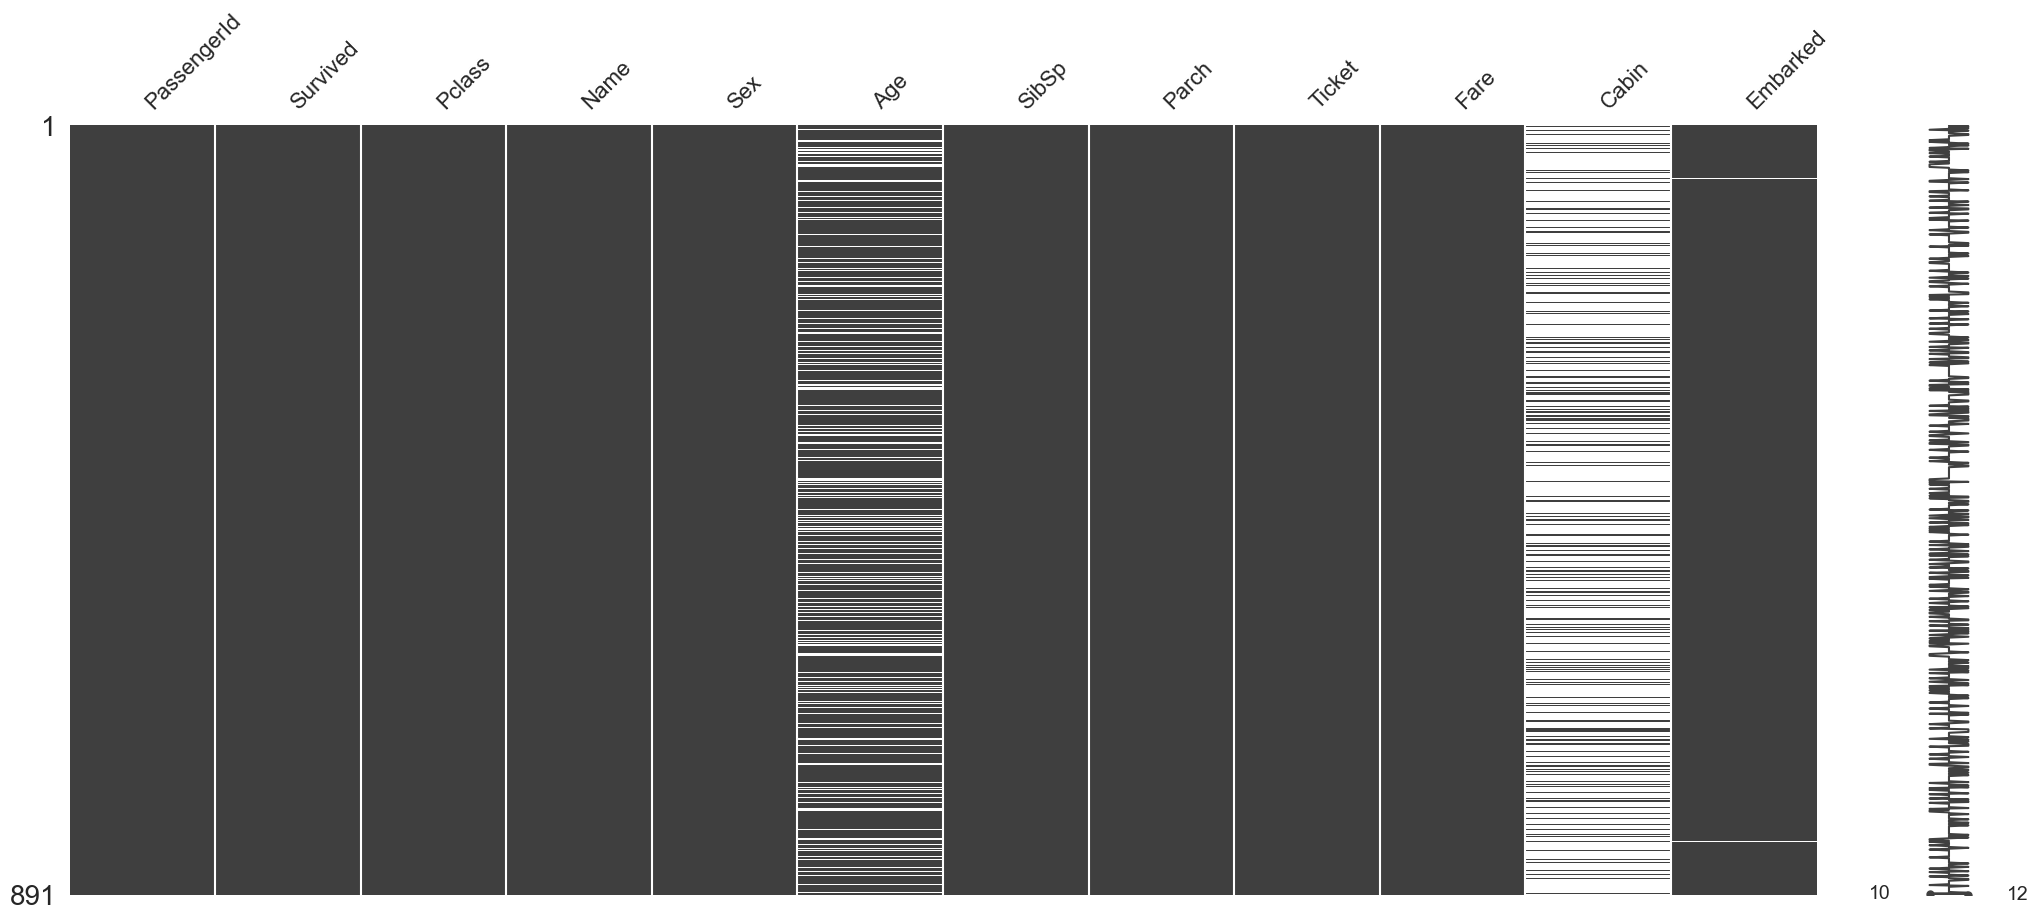

In [104]:
msno.matrix(titanic);

#### Матрица корреляции пропусков

In [105]:
# рассчитаем матрицу корреляции, когда известно в каких столбцах были пропуски
(titanic[["Age", "Cabin", "Embarked"]].isnull().corr())

,Age,Cabin,Embarked
Age,1.000000,0.144111,-0.023616
Cabin,0.144111,1.000000,-0.087042
Embarked,-0.023616,-0.087042,1.000000


In [106]:
# код для случаев, когда столбцы с пропусками неизвестны
df = titanic.iloc[
    :, [i for i, n in enumerate(np.var(titanic.isnull(), axis="rows")) if n > 0]
]
df.isnull().corr()  # type: ignore

,Age,Cabin,Embarked
Age,1.000000,0.144111,-0.023616
Cabin,0.144111,1.000000,-0.087042
Embarked,-0.023616,-0.087042,1.000000


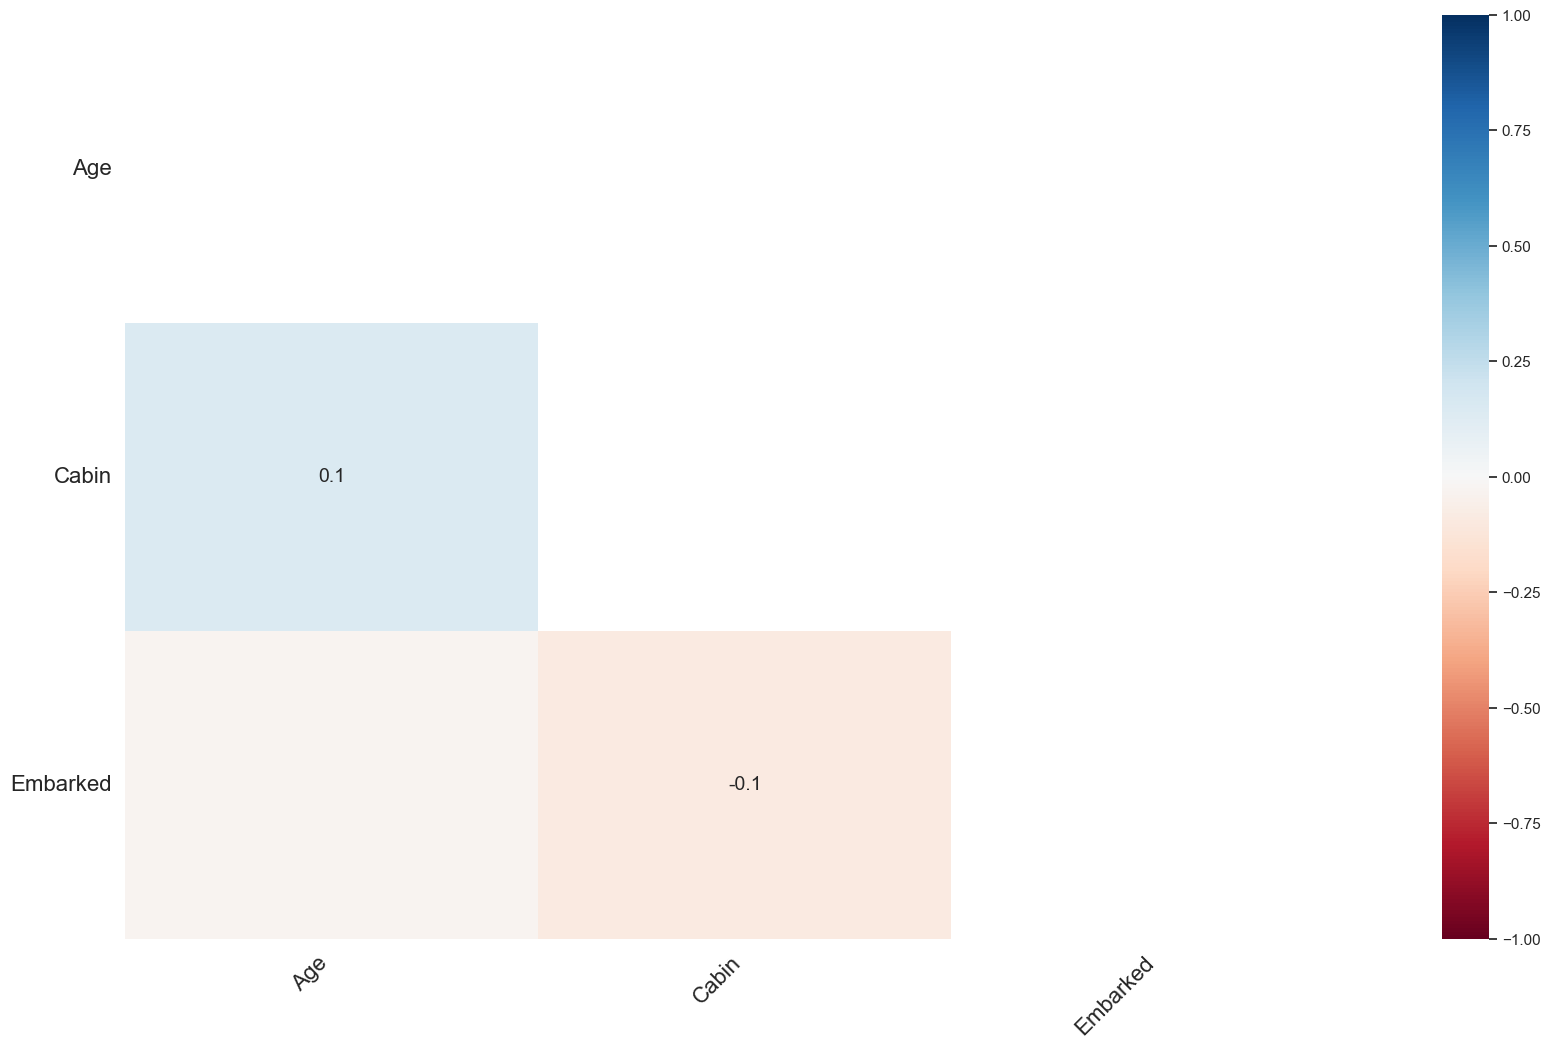

In [107]:
msno.heatmap(titanic);

## Удаление пропусков

### Удаление строк

In [108]:
# удаление строк обозначим через axis = 'index'
# subset = ['Embarked'] говорит о том, что мы ищем пропуски только в столбце Embarked
titanic.dropna(axis="index", subset=["Embarked"], inplace=True)

In [109]:
# убедимся, что в Embarked действительно не осталось пропусков
titanic.Embarked.isna().sum()

np.int64(0)

### Удаление столбцов

In [110]:
# передадим в параметр columns тот столбец, который хотим удалить
titanic.drop(columns=["Cabin"], inplace=True)

In [111]:
# убедимся, что такого столбца больше нет
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

### Pairwise deletion

In [112]:
# рассчитаем количество мужчик и женщин по каждому из признаков
sex_g = titanic.groupby("Sex").count()
sex_g

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked
Sex,,,,,,,,,,
female,312,312,312,312,259,312,312,312,312,312
male,577,577,577,577,453,577,577,577,577,577


In [113]:
# сравним количество пассажиров в столбце Age и столбце PassengerId
# мы видим, что метод .count() игнорировал пропуски
print(sex_g["PassengerId"].sum(), sex_g["Age"].sum())

889 712


In [114]:
# метод .mean() также игнорирует пропуски и не выдает ошибки
titanic["Age"].mean()

np.float64(29.64209269662921)

In [115]:
# то же можно сказать про метод .corr()
titanic[["Age", "Fare"]].corr()

,Age,Fare
Age,1.000000,0.093143
Fare,0.093143,1.000000


## Заполнение пропусков

Подготовка данных

In [ ]:
train_csv_url = os.environ.get("TRAIN_CSV_URL", "")
response = requests.get(train_csv_url)

# еще раз загрузим датасет "Титаник", в котором снова будут пропущенные значения
titanic = pd.read_csv(io.BytesIO(response.content))

# возьмем лишь некоторые из столбцов
titanic = titanic[["Pclass", "Sex", "SibSp", "Parch", "Fare", "Age", "Embarked"]]

# закодируем столбец Sex с помощью числовых значений
map_dict = {"male": 0, "female": 1}
titanic["Sex"] = titanic["Sex"].map(map_dict)

# посмотрим на результат
titanic.head()

,Pclass,Sex,SibSp,Parch,Fare,Age,Embarked
0,3,0,1,0,7.2500,22.0,S
1,1,1,1,0,71.2833,38.0,C
2,3,1,0,0,7.9250,26.0,S
3,1,1,1,0,53.1000,35.0,S
4,3,0,0,0,8.0500,35.0,S


### Одномерные методы

#### Заполнение константой

Метод `.fillna()`

Количественные данные

In [117]:
# вначале сделаем копию датасета
fillna_const = titanic.copy()

# заполним пропуски в столбце Age нулями, передав методу .fillna() словарь,
# где ключами будут названия столбцов, а значениями - константы для заполнения пропусков
fillna_const.fillna({"Age": 0}, inplace=True)

In [118]:
# посмотрим, как такое заполнение отразилось на данных
print(
    "titanic.Age.median():",
    titanic.Age.median(),
    " | fillna_const.Age.median():",
    fillna_const.Age.median(),
)

titanic.Age.median(): 28.0  | fillna_const.Age.median(): 24.0


Категориальные данные

In [ ]:
train_csv_url = os.environ.get("TRAIN_CSV_URL", "")
response = requests.get(train_csv_url)

# найдем пассажиров с неизвестным портом посадки
# для этого создадим маску по столбцу Embarked и применим ее к исходным данным
missing_embarked = pd.read_csv(io.BytesIO(response.content))
print(missing_embarked[missing_embarked.Embarked.isnull()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [120]:
# метод .fillna() можно применить к одному столбцу
# два пропущенных значения в столбце Embarked заполним буквой S (Southampton)
fillna_const["Embarked"] = fillna_const.Embarked.fillna("S")

In [121]:
# убедимся, что в столбцах Age и Embarked не осталось пропущенных значений
fillna_const[["Age", "Embarked"]].isna().sum()

Age         0
Embarked    0
dtype: int64

SimpleImputer

In [ ]:
const_imputer = titanic.copy()


# создадим объект этого класса, указав,
# что мы будем заполнять константой strategy = 'constant', а именно нулем fill_value = 0
imp_const = SimpleImputer(strategy="constant", fill_value=0)

# и обучим модель на столбце Age
# мы используем двойные скобки, потому что метод .fit() на вход принимает двумерный массив
imp_const.fit(const_imputer[["Age"]])

SimpleImputer(fill_value=0, strategy='constant')

In [123]:
# также используем двойные скобки с методом .transform()
const_imputer["Age"] = imp_const.transform(const_imputer[["Age"]])

# убедимся, что пропусков не осталось и посчитаем количество нулевых значений
print(
    "Пустых значений Age:",
    const_imputer.Age.isna().sum(),
    "| Кол-во замен на 0:",
    (const_imputer["Age"] == 0).sum(),
)

Пустых значений Age: 0 | Кол-во замен на 0: 177


In [124]:
# для дальнейшей работы столбец Embarked нам не понадобится, удалим его
const_imputer.drop(columns=["Embarked"], inplace=True)

# посмотрим на размер получившегося датафрейма
const_imputer.shape

(891, 6)

In [125]:
# посмотрим на результат
const_imputer.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3,0,1,0,7.2500,22.0
1,1,1,1,0,71.2833,38.0
2,3,1,0,0,7.9250,26.0


#### Заполнение средним арифметическим или медианой

Метод `.fillna()`

In [126]:
# fmt: off
# сделаем копию датафрейма
fillna_median = titanic.copy()

# заполним пропуски в столбце Age медианным значением возраста,
# можно заполнить и средним арифметическим через метод .mean()
fillna_median["Age"] = fillna_median["Age"].fillna(
    fillna_median["Age"].median()
)

# убедимся, что пропусков не осталось
fillna_median.Age.isna().sum()
# fmt: on

np.int64(0)

SimpleImputer

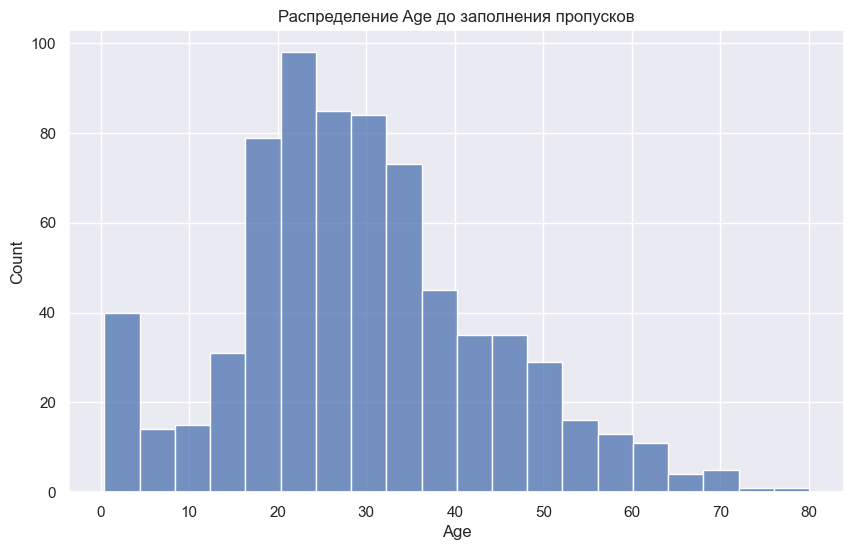

In [127]:
# изменим размер последующих графиков
sns.set(rc={"figure.figsize": (10, 6)})

# скопируем датафрейм
median_imputer = titanic.copy()

# посмотрим на распределение возраста до заполнения пропусков
sns.histplot(median_imputer["Age"], bins=20)
plt.title("Распределение Age до заполнения пропусков");

In [ ]:
# посмотрим на среднее арифметическое и медиану
# median_imputer["Age"].mean().round(1), median_imputer["Age"].median()
print(round(median_imputer["Age"].mean(), 1), median_imputer["Age"].median())

29.7 28.0


In [ ]:
imp_median = SimpleImputer(strategy="median")

# применим метод .fit_transform() для одновременного обучения
# модели и заполнения пропусков
median_imputer["Age"] = imp_median.fit_transform(median_imputer[["Age"]])

# убедимся, что пропущенных значений не осталось
median_imputer.Age.isna().sum()
# fmt: on

np.int64(0)

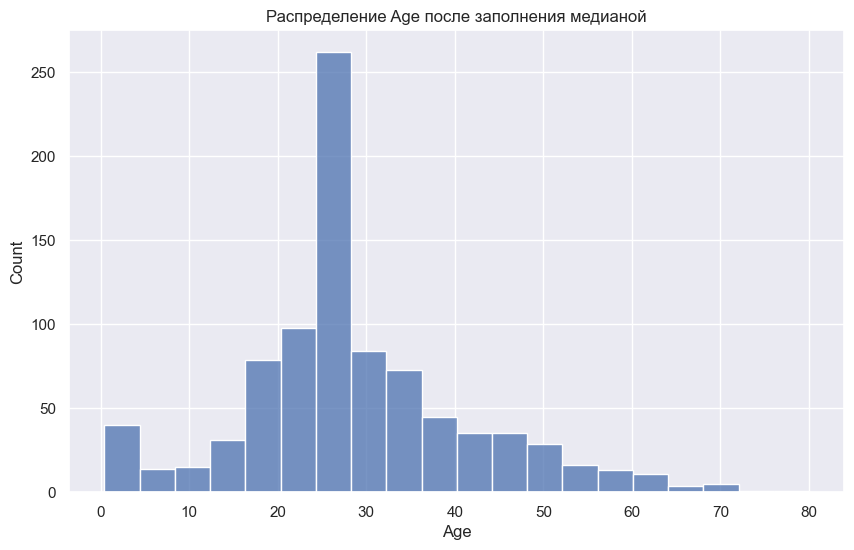

In [130]:
# посмотрим на распределение после заполнения пропусков
sns.histplot(median_imputer["Age"], bins=20)
plt.title("Распределение Age после заполнения медианой");

In [131]:
# посмотрим на метрики после заполнения медианой
# median_imputer["Age"].mean().round(1), median_imputer["Age"].median()
print(round(median_imputer["Age"].mean(), 1), median_imputer["Age"].median())

29.4 28.0


In [132]:
# столбец Embarked нам опять же не понадобится
median_imputer.drop(columns=["Embarked"], inplace=True)

# посмотрим на размеры получившегося датафрейма
median_imputer.shape

(891, 6)

#### Заполнение внутригрупповым значением

In [133]:
# скопируем датафрейм
median_imputer_bins = titanic.copy()

In [134]:
# выберем столбец 'Age'
# заполним пропуски в столбце 'Age', выполнив группировку по 'Sex','Pclass' и
# применив функцию 'median' через метод .transform()
median_imputer_bins["Age"] = median_imputer_bins["Age"].fillna(
    median_imputer_bins.groupby(["Sex", "Pclass"])["Age"].transform("median")
)

In [135]:
# проверим пропуски в столбце Age
median_imputer_bins.Age.isna().sum()

np.int64(0)

In [136]:
# столбец Embarked нам опять же не понадобится
median_imputer_bins.drop(columns=["Embarked"], inplace=True)

# посмотрим на размеры получившегося датафрейма
median_imputer_bins.shape

(891, 6)

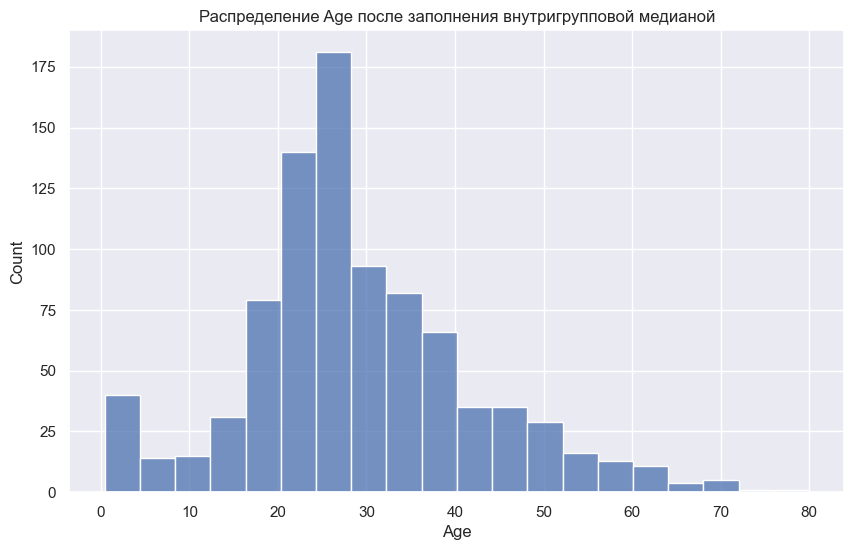

In [137]:
sns.histplot(median_imputer_bins["Age"], bins=20)
plt.title("Распределение Age после заполнения внутригрупповой медианой");

#### Заполнение наиболее частотным значением

In [138]:
# скопируем датафрейм
titanic_mode = titanic.copy()

# посмотрим на распределение пассажиров по порту посадки до заполнения пропусков
titanic_mode.groupby("Embarked")["Sex"].count()

Embarked
C    168
Q     77
S    644
Name: Sex, dtype: int64

In [ ]:
# создадим объект класса SimpleImputer с параметром strategy = 'most_frequent'
imp_most_freq = SimpleImputer(strategy="most_frequent")

In [140]:
# применим метод .fit_transform() к столбцу Embarked
titanic_mode["Embarked"] = imp_most_freq.fit_transform(
    titanic_mode[["Embarked"]]
).ravel()

In [141]:
# убедимся, что пропусков не осталось
titanic_mode.Embarked.isna().sum()

np.int64(0)

In [142]:
# проверим результат
# количество пассажиров в категории S должно увеличиться на два
titanic_mode.groupby("Embarked")["Sex"].count()

Embarked
C    168
Q     77
S    646
Name: Sex, dtype: int64

In [143]:
# найти моду можно также так
print(titanic.Embarked.value_counts().index[0])

S


In [144]:
# или так
imp_most_freq.statistics_

array(['S'], dtype=object)

In [145]:
# для работы с последующими методами столбец Embarked нам уже не нужен
titanic.drop(columns=["Embarked"], inplace=True)

### Многомерные методы

#### Линейная регрессия

##### Детерминированный подход

Подготовка данных

In [ ]:
lr = titanic.copy()


# создаем объект этого класса
scaler = StandardScaler()

# применяем метод .fit_transform() и сразу помещаем результат в датафрейм
lr = pd.DataFrame(scaler.fit_transform(lr), columns=lr.columns)

# посмотрим на результат
lr.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445,-0.530377
1,-1.566107,1.355574,0.432793,-0.473674,0.786845,0.571831
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854,-0.254825


In [147]:
# поместим в датафрейм test те строки, в которых в столбце Age есть пропуски
test = lr[lr["Age"].isnull()].copy()
test.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
5,0.827377,-0.737695,-0.474545,-0.473674,-0.478116,NaN
17,-0.369365,-0.737695,-0.474545,-0.473674,-0.386671,NaN
19,0.827377,1.355574,-0.474545,-0.473674,-0.502949,NaN


In [148]:
# посмотрим на количество таких строк
test.shape

(177, 6)

In [149]:
# в train напротив окажутся те строки, где в Age пропусков нет
train = lr.dropna().copy()

# оценим их количество
train.shape

(714, 6)

In [ ]:
# вместе train + test должны давать 891 строку
print(len(train) + len(test))

891


In [151]:
# из датафрейма train выделим столбец Age, это будет наша целевая переменная
y_train = train["Age"]

# из датафрейма признаков столбец Age нужно удалить
X_train = train.drop("Age", axis=1)

# в test столбец Age в принципе не нужен
X_test = test.drop("Age", axis=1)

In [152]:
# оценим результаты
X_train.head(3)

,Pclass,Sex,SibSp,Parch,Fare
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445
1,-1.566107,1.355574,0.432793,-0.473674,0.786845
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854


In [153]:
y_train.head(3)

0   -0.530377
1    0.571831
2   -0.254825
Name: Age, dtype: float64

In [154]:
X_test.head(3)

,Pclass,Sex,SibSp,Parch,Fare
5,0.827377,-0.737695,-0.474545,-0.473674,-0.478116
17,-0.369365,-0.737695,-0.474545,-0.473674,-0.386671
19,0.827377,1.355574,-0.474545,-0.473674,-0.502949


Обучение модели и заполнение пропусков

In [155]:
# создадим объект этого класса
lr_model = LinearRegression()

# обучим модель
lr_model.fit(X_train, y_train)

# применим обученную модель к данным, в которых были пропуски в столбце Age
y_pred = lr_model.predict(X_test)

# посмотрим на первые три прогнозных значения
y_pred[:3]

array([-0.09740093,  0.37999257, -0.31925429])

In [156]:
# присоединим прогнозные значения возраста к датафрейму test
test["Age"] = y_pred
test.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
5,0.827377,-0.737695,-0.474545,-0.473674,-0.478116,-0.097401
17,-0.369365,-0.737695,-0.474545,-0.473674,-0.386671,0.379993
19,0.827377,1.355574,-0.474545,-0.473674,-0.502949,-0.319254


In [157]:
# в train столбец Age присутствовал изначально
train.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445,-0.530377
1,-1.566107,1.355574,0.432793,-0.473674,0.786845,0.571831
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854,-0.254825


In [158]:
# соединим датафреймы методом "один на другой"
lr = pd.concat([train, test])
lr.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445,-0.530377
1,-1.566107,1.355574,0.432793,-0.473674,0.786845,0.571831
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854,-0.254825
3,-1.566107,1.355574,0.432793,-0.473674,0.420730,0.365167
4,0.827377,-0.737695,-0.474545,-0.473674,-0.486337,0.365167
6,-1.566107,-0.737695,-0.474545,-0.473674,0.395814,1.674039
7,0.827377,-0.737695,2.247470,0.767630,-0.224083,-1.908136


In [159]:
# соединим датафреймы методом "один на другой"
lr = pd.concat([train, test])
lr.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445,-0.530377
1,-1.566107,1.355574,0.432793,-0.473674,0.786845,0.571831
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854,-0.254825
3,-1.566107,1.355574,0.432793,-0.473674,0.420730,0.365167
4,0.827377,-0.737695,-0.474545,-0.473674,-0.486337,0.365167
6,-1.566107,-0.737695,-0.474545,-0.473674,0.395814,1.674039
7,0.827377,-0.737695,2.247470,0.767630,-0.224083,-1.908136


In [160]:
# восстановим изначальный порядок строк, отсортировав их по индексу
lr.sort_index(inplace=True)
lr.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,0.827377,-0.737695,0.432793,-0.473674,-0.502445,-0.530377
1,-1.566107,1.355574,0.432793,-0.473674,0.786845,0.571831
2,0.827377,1.355574,-0.474545,-0.473674,-0.488854,-0.254825
3,-1.566107,1.355574,0.432793,-0.473674,0.420730,0.365167
4,0.827377,-0.737695,-0.474545,-0.473674,-0.486337,0.365167
5,0.827377,-0.737695,-0.474545,-0.473674,-0.478116,-0.097401
6,-1.566107,-0.737695,-0.474545,-0.473674,0.395814,1.674039


In [161]:
# вернем исходный масштаб с помощью метода .inverse_transform()
lr = pd.DataFrame(scaler.inverse_transform(lr), columns=lr.columns)

# округлим столбец Age и выведем результат
lr.Age = lr.Age.round(1)
lr.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3.0,0.0,1.0,0.0,7.2500,22.0
1,1.0,1.0,1.0,0.0,71.2833,38.0
2,3.0,1.0,0.0,0.0,7.9250,26.0
3,1.0,1.0,1.0,0.0,53.1000,35.0
4,3.0,0.0,0.0,0.0,8.0500,35.0
5,3.0,0.0,0.0,0.0,8.4583,28.3
6,1.0,0.0,0.0,0.0,51.8625,54.0


In [162]:
# восстановив значение возраста первого наблюдения вручную
# (-0.530377 * titanic.Age.std() + titanic.Age.mean()).round()
round(-0.530377 * titanic.Age.std() + titanic.Age.mean())

22

In [163]:
# убедимся в отсутствии пропусков и посмотрим на размеры получившегося датафрейма
print("Пропусков в Age:", lr.Age.isna().sum(), "| Размер датафрейма:", lr.shape)

Пропусков в Age: 0 | Размер датафрейма: (891, 6)


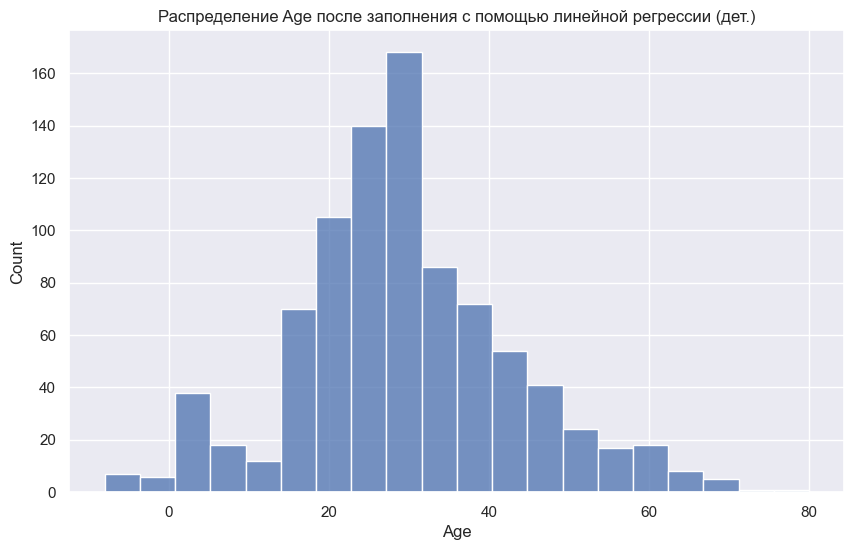

In [164]:
# посмотрим на распределение возраста после заполнения пропусков
sns.histplot(lr["Age"], bins=20)
plt.title("Распределение Age после заполнения с помощью линейной регрессии (дет.)");

In [165]:
# чтобы возраст был только положительным,
# установим минимальное значение на уровне 0,5
lr["Age"] = lr.Age.clip(lower=0.5)

In [166]:
# посмотрим, как изменились среднее арифметическое и медиана
print("Среднее Age:", lr.Age.mean().round(1), "| Медиана Age:", lr.Age.median())

Среднее Age: 29.3 | Медиана Age: 28.3


Особенность детерминированного подхода

In [167]:
# fmt: off
# сделаем копию датафрейма, которую используем для визуализации
lr_viz = lr.copy()

# создадим столбец Age_type, в который запишем значение actual, 
# если индекс наблюдения есть в train,
# и imputed, если нет (т.е. он есть в test)
lr_viz["Age_type"] = np.where(
    lr.index.isin(train.index),
    "actual",
    "imputed",
)

# вновь "обрежем" нулевые значения
lr_viz["Age"] = lr_viz.Age.clip(lower=0.5)

# посмотрим на результат
lr_viz.head(7)
# fmt: on

,Pclass,Sex,SibSp,Parch,Fare,Age,Age_type
0,3.0,0.0,1.0,0.0,7.2500,22.0,actual
1,1.0,1.0,1.0,0.0,71.2833,38.0,actual
2,3.0,1.0,0.0,0.0,7.9250,26.0,actual
3,1.0,1.0,1.0,0.0,53.1000,35.0,actual
4,3.0,0.0,0.0,0.0,8.0500,35.0,actual
5,3.0,0.0,0.0,0.0,8.4583,28.3,imputed
6,1.0,0.0,0.0,0.0,51.8625,54.0,actual


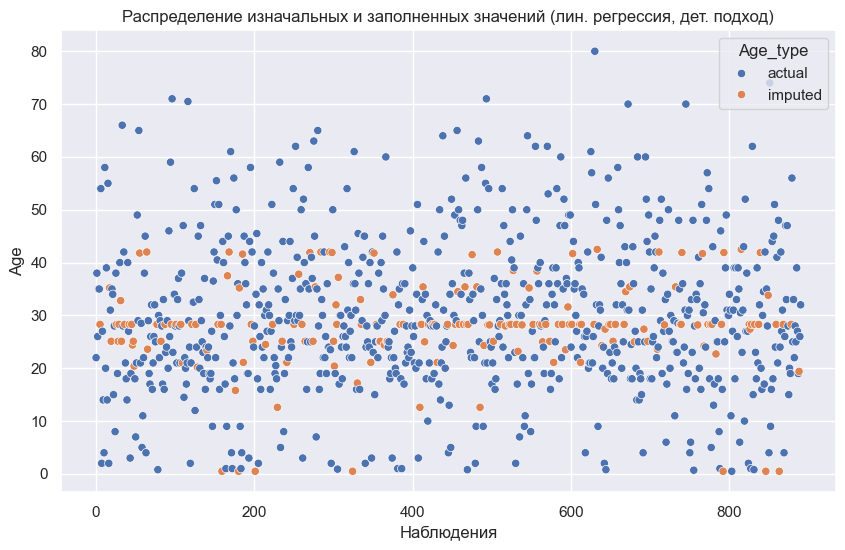

In [168]:
# создадим график, где по оси x будет индекс датафрейма,
# по оси y - возраст, а цветом мы обозначим изначальное это значение, или заполненное
sns.scatterplot(data=lr_viz, x=lr_viz.index, y="Age", hue="Age_type")
plt.title(
    "Распределение изначальных и заполненных значений (лин. регрессия, дет. подход)"
)
plt.xlabel("Наблюдения");

In [169]:
# рассчитаем СКО для исходных и заполненных значений
print(
    "STD actual:",
    np.round(lr_viz[lr_viz["Age_type"] == "actual"].Age.std(), 2),
    "| STD imputed:",
    np.round(lr_viz[lr_viz["Age_type"] == "imputed"].Age.std(), 2),
)

STD actual: 14.53 | STD imputed: 8.33


##### Стохастический подход

In [ ]:
# объявим функцию для создания гауссовского шума
# на входе эта функция будет принимать некоторый массив значений x,
# среднее значение mu, СКО std и точку отсчета для воспроизводимости результата


def gaussian_noise(
    x_var: ArrayLike, mu: float = 0.0, std: float = 1.0, random_state: int = 42
) -> np.ndarray:
    """Return values with added gaussian noise."""
    # вначале создадим объект, который позволит получать воспроизводимые результаты
    arr = np.asarray(x_var, dtype=np.float64)

    rs = np.random.RandomState(random_state)

    # применим метод .normal() к этому объекту для создания гауссовского шума
    noise = rs.normal(mu, std, size=arr.shape)

    # добавим шум к исходному массиву
    result: np.ndarray = arr + noise
    return result

In [171]:
# заменим заполненные значения теми же значениями, но с добавлением шума
test["Age"] = gaussian_noise(x_var=test["Age"])

# посмотрим, как изменились заполненные значения
test.head(3)

,Pclass,Sex,SibSp,Parch,Fare,Age
5,0.827377,-0.737695,-0.474545,-0.473674,-0.478116,0.399313
17,-0.369365,-0.737695,-0.474545,-0.473674,-0.386671,0.241728
19,0.827377,1.355574,-0.474545,-0.473674,-0.502949,0.328434


In [ ]:
# fmt: off
# соединим датасеты и обновим индекс
lr_stochastic = pd.concat([train, test])
lr_stochastic.sort_index(inplace=True)

# вернем исходный масштаб с помощью метода .inverse_transform()
lr_stochastic = pd.DataFrame(
    scaler.inverse_transform(lr_stochastic),
    columns=lr_stochastic.columns
)

# округлим столбец Age и выведем результат
lr_stochastic.Age = lr_stochastic.Age.round(1)
lr_stochastic.head(7)
# fmt: on

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3.0,0.0,1.0,0.0,7.2500,22.0
1,1.0,1.0,1.0,0.0,71.2833,38.0
2,3.0,1.0,0.0,0.0,7.9250,26.0
3,1.0,1.0,1.0,0.0,53.1000,35.0
4,3.0,0.0,0.0,0.0,8.0500,35.0
5,3.0,0.0,0.0,0.0,8.4583,35.5
6,1.0,0.0,0.0,0.0,51.8625,54.0


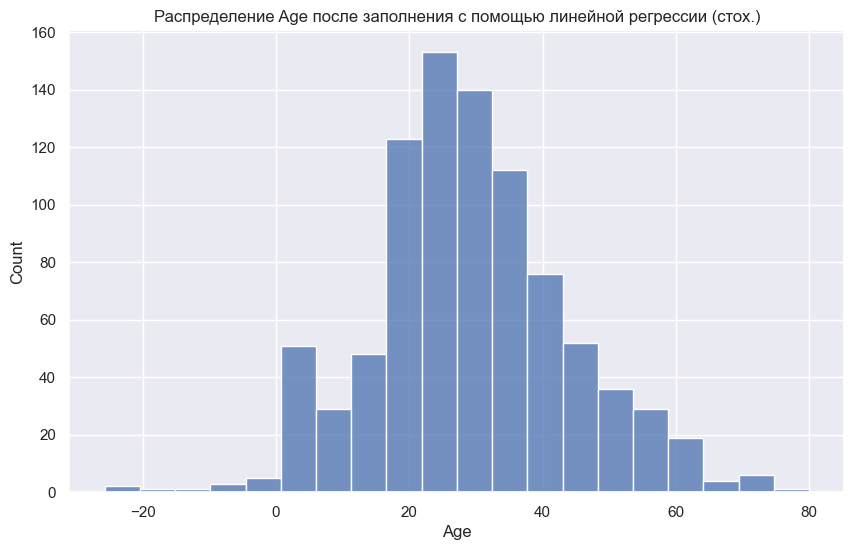

In [173]:
# посмотрим на распределение возраста
# после заполнения пропусков с помощью стохастического подхода
sns.histplot(lr_stochastic["Age"], bins=20)
plt.title("Распределение Age после заполнения с помощью линейной регрессии (стох.)");

In [174]:
# обрежем нулевые и отрицательные значения
lr_stochastic["Age"] = lr_stochastic.Age.clip(lower=0.5)

In [ ]:
# посмотрим на среднее арифметическое и медиану
print(lr_stochastic.Age.mean().round(1), lr_stochastic.Age.median())

29.3 28.0


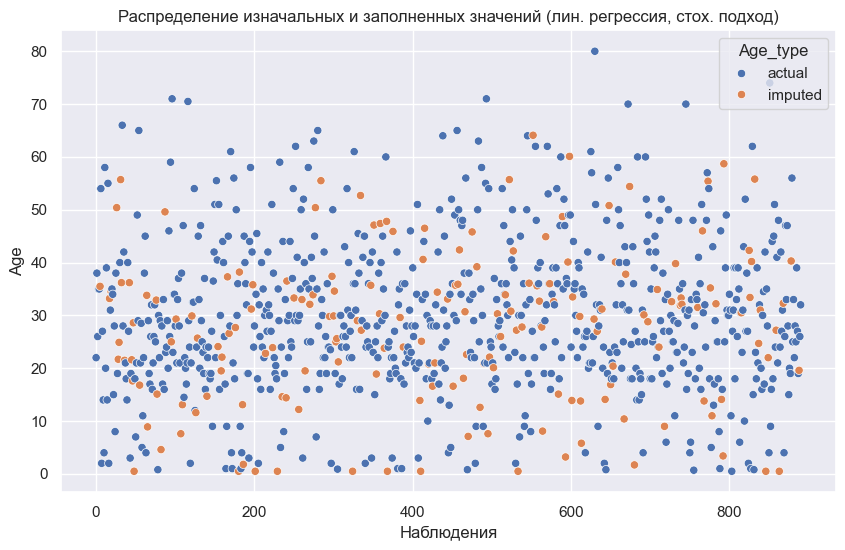

In [ ]:
# сделаем копию датафрейма, которую используем для визуализации
lr_st_viz = lr_stochastic.copy()

# создадим столбец Age_type, в который запишем actual, если индекс
# наблюдения # есть в train, и imputed, если нет (т.е. он есть в test)
lr_st_viz["Age_type"] = np.where(
    lr_stochastic.index.isin(train.index), "actual", "imputed"
)

# вновь "обрежем" нулевые значения
lr_st_viz["Age"] = lr_st_viz.Age.clip(lower=0.5)

# создадим график, где по оси x будет индекс датафрейма,
# по оси y - возраст, а цветом мы обозначим изначальное это значение, или заполненное
sns.scatterplot(data=lr_st_viz, x=lr_st_viz.index, y="Age", hue="Age_type")
plt.title(
    "Распределение изначальных и заполненных значений (лин. регрессия, стох. подход)"
)
plt.xlabel("Наблюдения");

In [177]:
# рассчитаем СКО для исходных и заполненных значений
print(
    np.round(lr_st_viz[lr_st_viz["Age_type"] == "actual"].Age.std(), 2),
    np.round(lr_st_viz[lr_st_viz["Age_type"] == "imputed"].Age.std(), 2),
)

14.53 14.34


#### MICE / IterativeImputer

In [178]:
# сделаем копию датасета для работы с методом MICE
mice = titanic.copy()

In [ ]:
scaler = StandardScaler()

# стандартизируем данные и сразу поместим их в датафрейм
mice = pd.DataFrame(scaler.fit_transform(mice), columns=mice.columns)

In [182]:
# создадим объект класса IterativeImputer и укажем необходимые параметры
mice_imputer = IterativeImputer(
    initial_strategy="mean",  # вначале заполним пропуски средним значением
    estimator=LinearRegression(),  # в качестве модели используем линейную регрессию
    random_state=42,  # добавим точку отсчета
)

# используем метод .fit_transform() для заполнения пропусков в датасете mice
mice = mice_imputer.fit_transform(mice)

# вернем данные к исходному масштабу и округлим столбец Age
mice = pd.DataFrame(scaler.inverse_transform(mice), columns=titanic.columns)
mice.Age = mice.Age.round(1)
mice.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3.0,0.0,1.0,0.0,7.2500,22.0
1,1.0,1.0,1.0,0.0,71.2833,38.0
2,3.0,1.0,0.0,0.0,7.9250,26.0
3,1.0,1.0,1.0,0.0,53.1000,35.0
4,3.0,0.0,0.0,0.0,8.0500,35.0
5,3.0,0.0,0.0,0.0,8.4583,28.3
6,1.0,0.0,0.0,0.0,51.8625,54.0


In [ ]:
# убедимся, что пропусков не осталось
print(mice.Age.isna().sum(), mice.shape)

(np.int64(0), (891, 6))

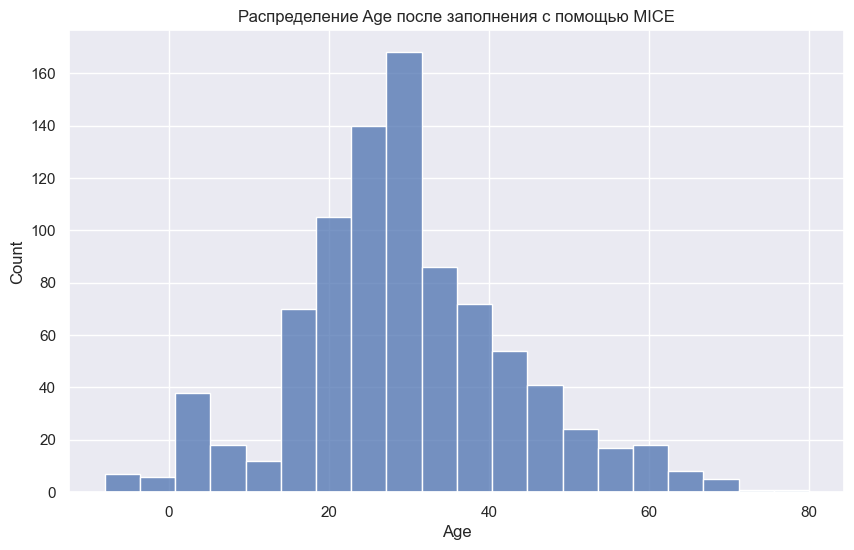

In [184]:
# посмотрим на гистограмму возраста после заполнения пропусков
sns.histplot(mice["Age"], bins=20)
plt.title("Распределение Age после заполнения с помощью MICE");

In [185]:
# обрежем нулевые и отрицательные значения
mice["Age"] = mice.Age.clip(lower=0.5)

In [ ]:
# оценим среднее арифметическое и медиану
print(mice.Age.mean().round(1), mice.Age.median())

(np.float64(29.3), np.float64(28.3))

In [ ]:
# сравним СКО исходного датасета и данных после алгоритма MICE
print(np.round(titanic.Age.std(), 2), np.round(mice.Age.std(), 2))

(np.float64(14.53), np.float64(13.54))

#### KNN Imputation

##### Sklearn KNNImputer

In [ ]:
# сделаем копию датафрейма
knn = titanic.copy()

# создадим объект класса StandardScaler
scaler = StandardScaler()

# масштабируем данные и сразу преобразуем их обратно в датафрейм
knn = pd.DataFrame(scaler.fit_transform(knn), columns=knn.columns)

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# заполним пропуски в столбце Age
knn = pd.DataFrame(knn_imputer.fit_transform(knn), columns=knn.columns)

# проверим отсутствие пропусков и размеры получившегося датафрейма
print(knn.Age.isna().sum(), knn.shape)

(np.int64(0), (891, 6))

In [190]:
# вернем исходный масштаб
knn = pd.DataFrame(scaler.inverse_transform(knn), columns=knn.columns)

# округлим значение возраста
knn.Age = knn.Age.round(1)

# посмотрим на результат
knn.head(7)

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3.0,0.0,1.0,0.0,7.2500,22.0
1,1.0,1.0,1.0,0.0,71.2833,38.0
2,3.0,1.0,0.0,0.0,7.9250,26.0
3,1.0,1.0,1.0,0.0,53.1000,35.0
4,3.0,0.0,0.0,0.0,8.0500,35.0
5,3.0,0.0,0.0,0.0,8.4583,24.2
6,1.0,0.0,0.0,0.0,51.8625,54.0


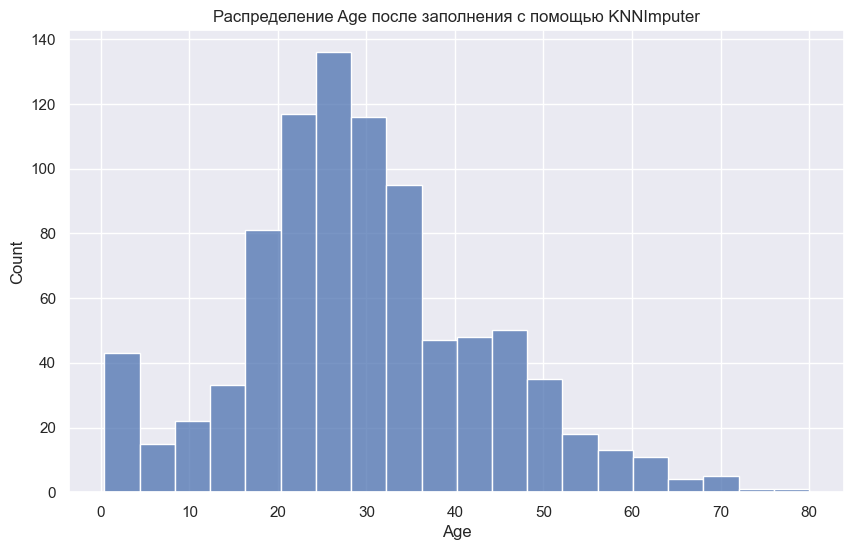

In [191]:
# посмотрим на распределение возраста после заполнения пропусков
sns.histplot(knn["Age"], bins=20)
plt.title("Распределение Age после заполнения с помощью KNNImputer");

#### Сравнение методов

In [192]:
# создадим два списка, в первый поместим датасеты с заполненными значениями
datasets = [
    const_imputer,
    median_imputer,
    median_imputer_bins,
    lr,
    lr_stochastic,
    mice,
    knn,
]

# во второй, названия методов
methods = [
    "constant",
    "median",
    "binned median",
    "linear regression",
    "stochastic linear regression",
    "MICE",
    "KNNImputer",
]

In [ ]:
train_csv_url = os.environ.get("TRAIN_CSV_URL", "")
response = requests.get(train_csv_url)

# возьмем целевую переменную из исходного файла
y_var = pd.read_csv(io.BytesIO(response.content))["Survived"]

In [ ]:
for X_smpl, method in zip(datasets, methods):

    # масштабируем признаки
    X_smpl = StandardScaler().fit_transform(X_smpl)

    # для каждого датасета построим и обучим модель логистической регрессии
    model = LogisticRegression()
    model.fit(X_smpl, y_var)

    # сделаем прогноз
    y_pred = model.predict(X_smpl)

    # выведем название использованного метода и достигнутую точность
    print(f"Method: {method}, accuracy: {np.round(accuracy_score(y_var, y_pred), 3)}")

Method: constant, accuracy: 0.79
Method: median, accuracy: 0.795
Method: binned median, accuracy: 0.808
Method: linear regression, accuracy: 0.808
Method: stochastic linear regression, accuracy: 0.796
Method: MICE, accuracy: 0.808
Method: KNNImputer, accuracy: 0.802


## Ответы на вопросы

**Вопрос**. Что делать, если пропуски заполнены каким-либо символом, а не NaN? Например, знаком вопроса.

In [ ]:
df_smpl: pd.DataFrame = pd.DataFrame([[1, 2, 3], ["?", 5, 6], [7, "?", 9]])

df_smpl

,0,1,2
0,1,2,3
1,?,5,6
2,7,?,9


In [197]:
df[df == "?"] = np.nan
df

,0,1,2
0,1,2,3
1,NaN,5,6
2,7,NaN,9
